# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 2

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Série temporal estacionária e não-linear

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Matheus dos Santos Rodrigues 

### 6.1. Importações e definições

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

### 6.2. Carregando a base de dados e apresentando sua composição

In [3]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

from google.colab import files
uploaded = files.upload()
import io

series = np.loadtxt("nlts.txt", dtype='f', delimiter=',')
series = series/15
series = series - np.mean(series)
print(series)

Saving nlts.txt to nlts.txt
[-0.86525667 -0.9468028  -0.99788886 ... -0.12370616  0.30464625
 -0.1738807 ]


### 6.3. Exibindo o comportamento temporal da série

Text(0, 0.5, 'Valor da série')

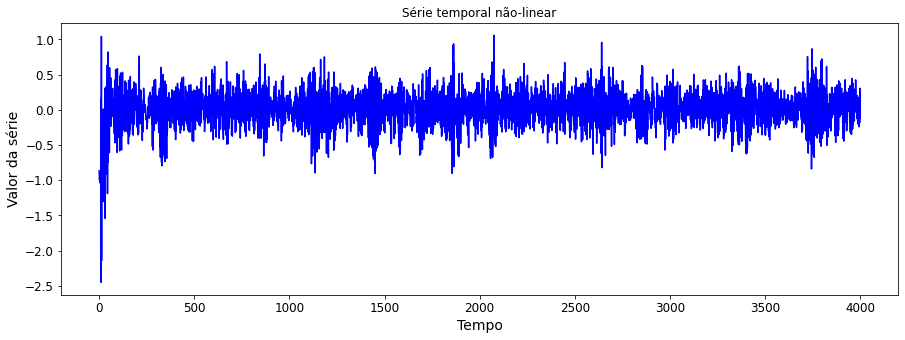

In [4]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal não-linear')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [5]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


### 6.5. Visualização do comportamento da série temporal de teste

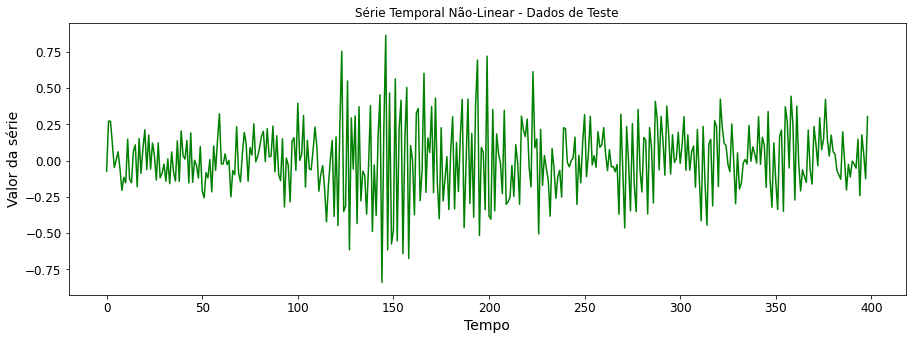

In [15]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [16]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[ 0.27299142  0.03401006 -0.18766307 -0.33875786  0.05451361  0.15593558
  0.22825877  0.44130719  0.05621329 -0.2540271   0.        ]


#### 6.6.1. Visualização do desempenho do preditor linear

In [17]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.043909087273997685
EQM final de validação após o término do treinamento - Preditor Linear
0.031301683631628635
EQM final de teste após o término do treinamento - Preditor Linear
0.04225981520778723


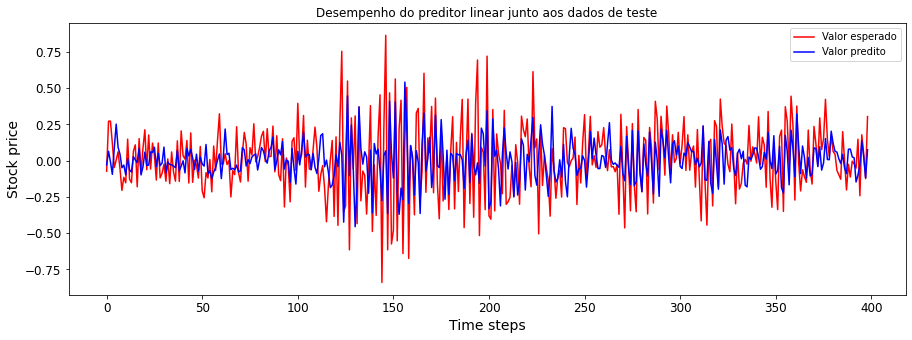

In [18]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [ ]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 4s 5ms/step - loss: 0.0627 - val_loss: 0.0324
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0402
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0368
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0310
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0305
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0336
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0311
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0330
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0326
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0411 - val_lo

In [ ]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

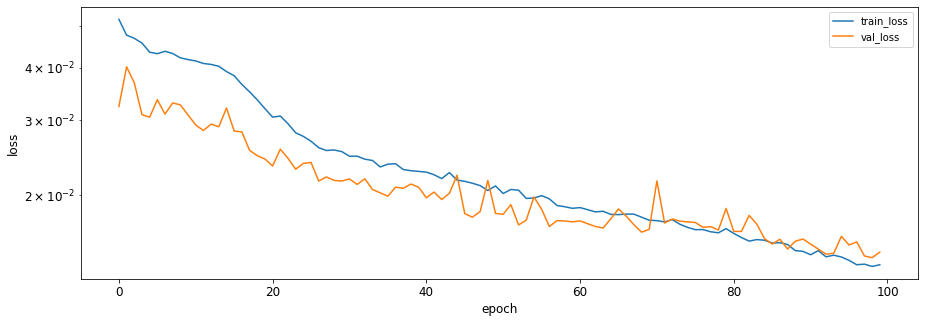

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [ ]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.012596783
EQM final de validação após o término do treinamento - Preditor MLP
0.014233277
EQM final de teste após o término do treinamento - Preditor MLP
0.018728208


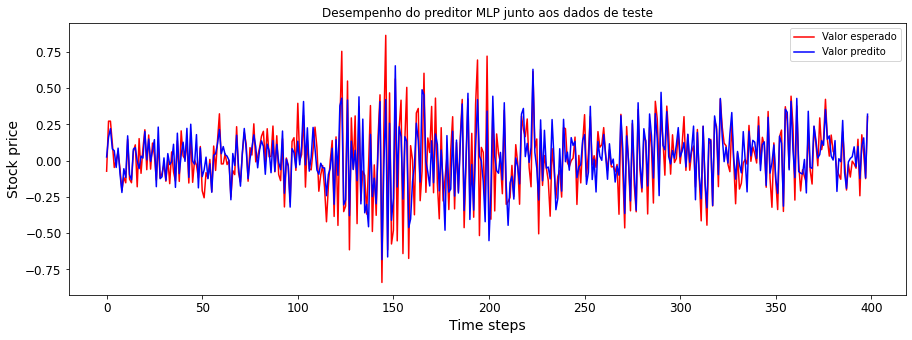

In [ ]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 3s 16ms/step - loss: 0.0936 - val_loss: 0.0316
Epoch 2/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0436 - val_loss: 0.0315
Epoch 3/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0452 - val_loss: 0.0289
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0417 - val_loss: 0.0282
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0394 - val_loss: 0.0272
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0387 - val_loss: 0.0271
Epoch 7/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0360 - val_loss: 0.0255
Epoch 8/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0366 - val_loss: 0.0244
Epoch 9/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0373 - val_loss: 0.0243
Epoch 10/100
1

In [ ]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

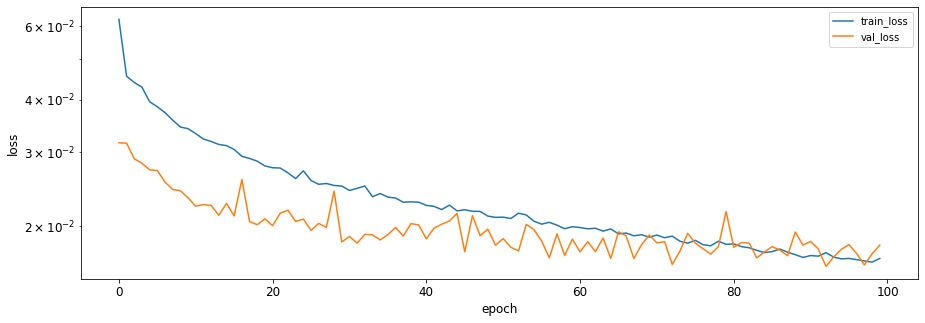

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.016017543
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.016005324
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.02016347


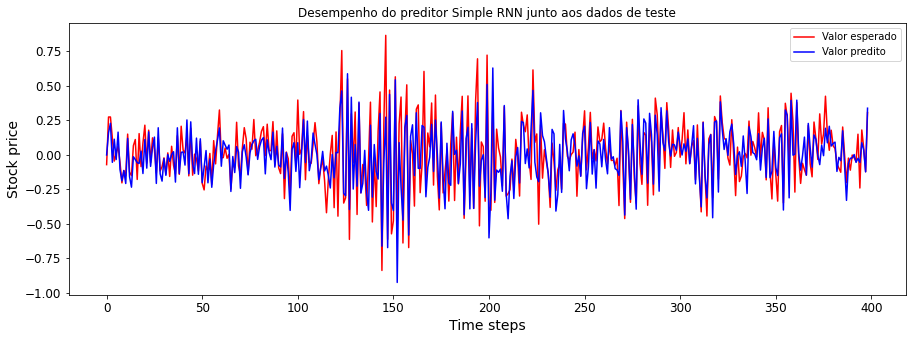

In [ ]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [ ]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Epoch 1/100
100/100 [==============================] - 32s 10ms/step - loss: 0.0677 - val_loss: 0.0532
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0607 - val_loss: 0.0536
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0657 - val_loss: 0.0530
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0614 - val_loss: 0.0530
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0635 - val_loss: 0.0528
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0623 - val_loss: 0.0536
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0603 - val_loss: 0.0529
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0627 - val_loss: 0.0528
Epoch 9/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0665 - val_loss: 0.0533
Epoch 10/100
100/100 

In [ ]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

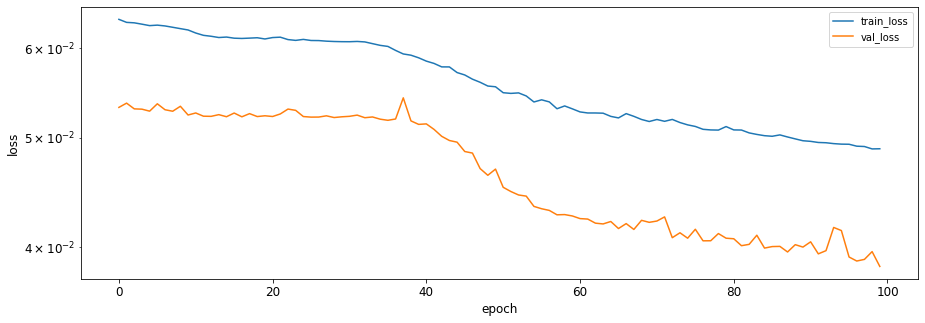

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
100/100 [==============================] - 0s 2ms/step - loss: 0.0484
EQM final de validação após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 2ms/step - loss: 0.0385
EQM final de teste após o término do treinamento - Preditor LSTM GRU
13/13 [==============================] - 0s 3ms/step - loss: 0.0484


0.04836990311741829

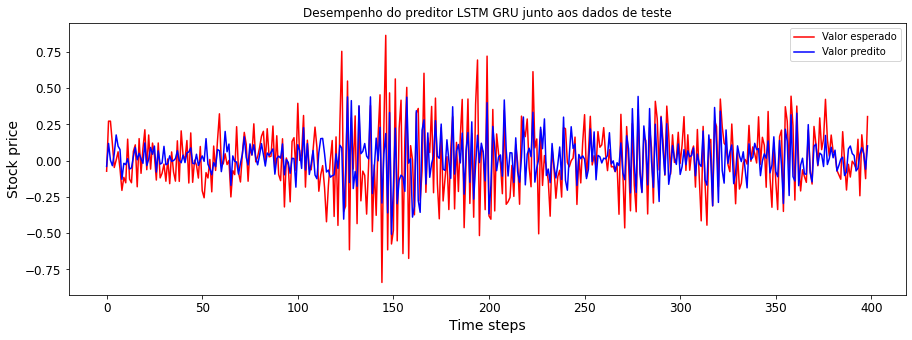

In [ ]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [ ]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [ ]:
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 5)             15        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Epoch 1/100
100/100 [==============================] - 2s 5ms/step - loss: 0.0696 - val_loss: 0.0437
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0384
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0355
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0340
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0326
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0313
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0296
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0288
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0279
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0429 - val_lo

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

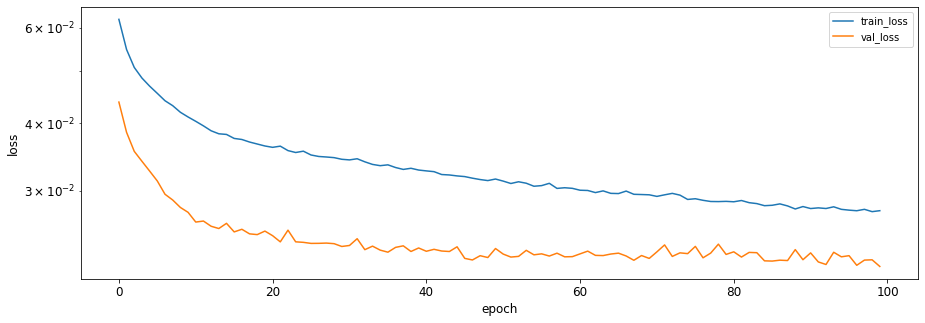

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [ ]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.027014365
EQM final de validação após o término do treinamento - Preditor CNN
0.021753166
EQM final de teste após o término do treinamento - Preditor CNN
0.028648205


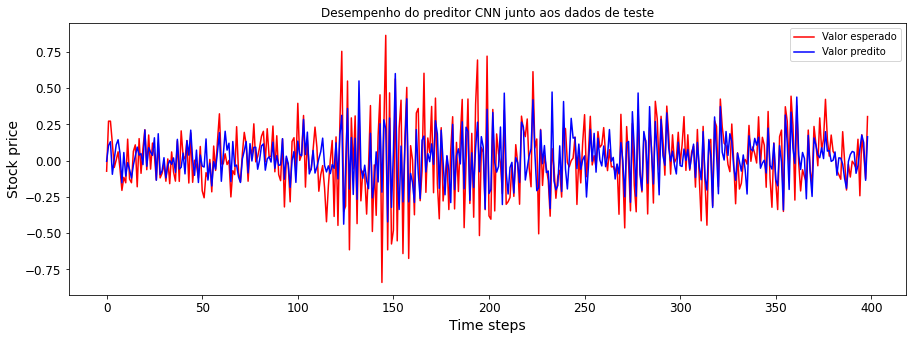

In [ ]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### RESPOSTAS

**6.2.1: Resumo geral**
Essencialmente foram seguidos os mesmos passos que os do notebook da "Parte 1", com as devidas adequações referentes as mudanças da base de dados.
* 6.1: Imports e defines necessários;
* 6.2: Carregamento da série temporal "nlts.txt";
* 6.3: Plot da série temporal;
* 6.4: Preprocessamento da série temporal, com definição do número de atrasos a ser considerados (seq_len=10), e particionamento dos dados em treinamento, validação e teste;
* 6.5: Plot da serie temporal de test;
* 6.6: Sítense do preditor linear; não é utilizada nenhuma regularização;
* 6.7: Sítense do preditor não linear MLP; é utilizado hold-out, porém também é usado *EarlyStopping* para monitorar 'val_loss' e guardar o melhor modelo (menor MAPE) ao invés do final do treinamento (100 épocas);
* 6.8: Sítense do preditor não linear recorrente Simple RNN; é utilizado hold-out, porém também é usado *EarlyStopping* para monitorar 'val_loss' e guardar o melhor modelo (menor MAPE) ao invés do final do treinamento (100 épocas);
* 6.9: Sítense do preditor não linear recorrente bloco LSTM GRU; é utilizado hold-out, porém também é usado *EarlyStopping* para monitorar 'val_loss' e guardar o melhor modelo (menor MAPE) ao invés do final do treinamento (100 épocas);
* 6.10: Sítense do preditor não linear CNN 1D; é utilizado hold-out, porém também é usado *EarlyStopping* para monitorar 'val_loss' e guardar o melhor modelo (menor MAPE) ao invés do final do treinamento (100 épocas);



**6.2.2:** Uma vez que a série temporal abordada possui uma dinâmica não linear (possivelmente determinística), possuindo uma região transiente e estacionária, os preditores não lineares apresentam melhor desempenho por possuir maior flexibilidade, e portanto, conseguem sintetizar um modelo que representa melhor a dinâmica do sistema. Assim, com uma representação mais competente, a predição também será mais acurada. Em contrapartida, uma vez que apenas combinação linear dos dados anteriores não é suficiente para uma predição satisfatória deste problema (pois não conseguem obter uma representação em um outro espaço de estados que caracterize a dinâmica do sistema), o perditor linear passa a ser o pior modelo dentre os testados. 

**6.2.3:** Several Steps ahead prediction:
foi utilizado um preditor MLP para fazer a previsão de 5 passos (n_steps = 5) à frente da série temporal. As previsões foram feitas todas de uma vez, isto é, a RNA possui *n_steps* outputs. 

### Implementação - 6.2.3

In [50]:
#Implementação multiple step forecasting
# function to create train, validation, test data 
def load_data(series, seq_len, n_steps):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-n_steps-1]
    y_train = data[:train_set_size,seq_len-n_steps+1:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-n_steps-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,seq_len-n_steps+1:]
    
    x_test = data[train_set_size+valid_set_size:,:-n_steps-1]
    y_test = data[train_set_size+valid_set_size:,seq_len-n_steps+1:]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)    
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)    
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
        
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
n_steps = 5 # Número de passos para previsao
seq_len = 10 + n_steps # Número de atrasos a serem considerados


x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len, n_steps)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3188, 10)
y_train.shape =  (3188, 5)
x_valid.shape =  (398, 10)
y_valid.shape =  (398, 5)
x_test.shape =  (398, 10)
y_test.shape =  (398, 5)


#### Sinteze do preditor MLP multi-step

In [51]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(n_steps)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 0.0548 - val_loss: 0.0396
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0393
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0390
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0381
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0391
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0395
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0381
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0390
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0383
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0485 - val_lo

In [52]:
model_MLP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 9,989
Trainable params: 9,989
Non-trainable params: 0
_________________________________________________________________


#### Carregando o modelo com o menor MAPE para o preditor MLP

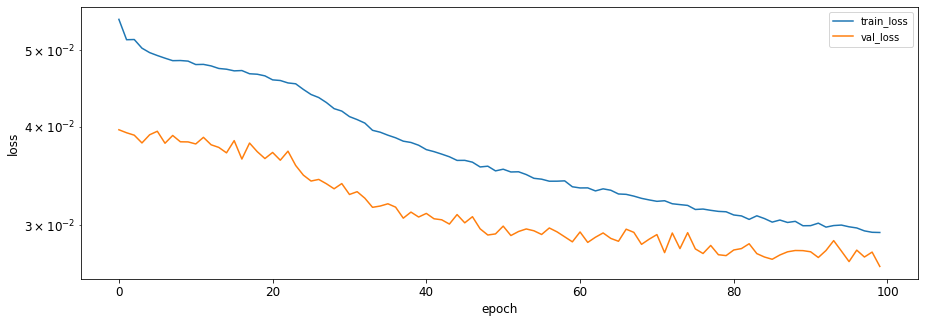

In [53]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### Visualização do desempenho do preditor MLP

In [60]:
#weights = model_MLP.get_weights()
#print(weights)
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.028613875
EQM final de validação após o término do treinamento - Preditor MLP
0.026564112
EQM final de teste após o término do treinamento - Preditor MLP
0.03371823


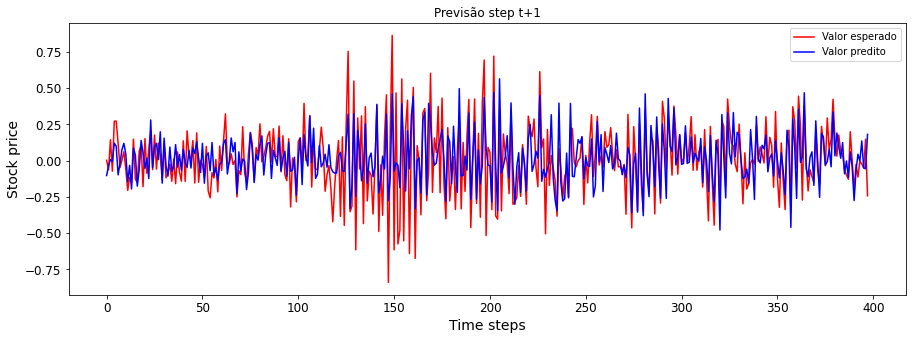

In [61]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test[:,0], color='red', label='Valor esperado')
plt.plot(y_pred[:,0], color='blue', label='Valor predito')
plt.title('Previsão step t+1')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

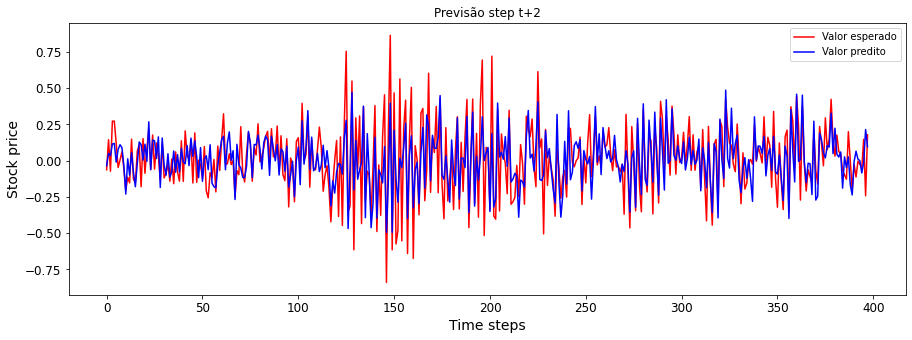

In [62]:
plt.figure(figsize=(15, 5));
plt.plot(y_test[:,1], color='red', label='Valor esperado')
plt.plot(y_pred[:,1], color='blue', label='Valor predito')
plt.title('Previsão step t+2')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

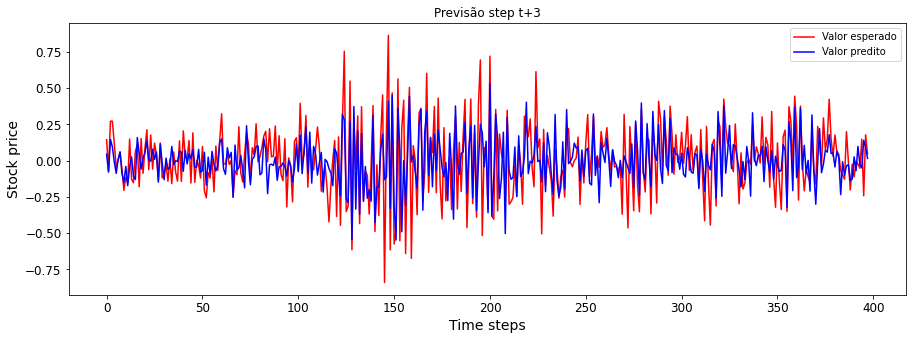

In [63]:
plt.figure(figsize=(15, 5));
plt.plot(y_test[:,2], color='red', label='Valor esperado')
plt.plot(y_pred[:,2], color='blue', label='Valor predito')
plt.title('Previsão step t+3')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

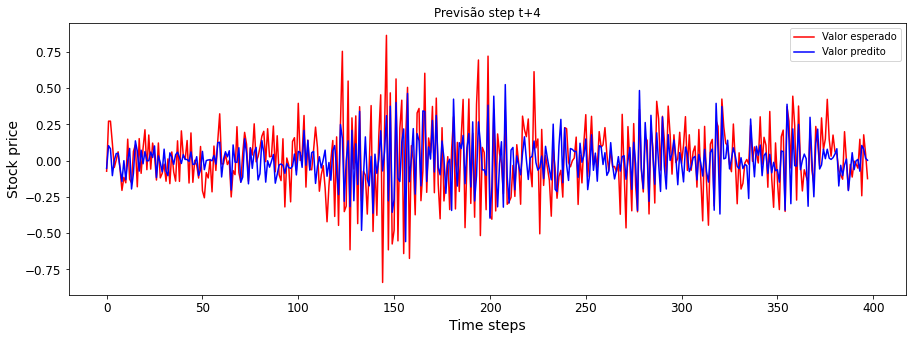

In [64]:
plt.figure(figsize=(15, 5));
plt.plot(y_test[:,3], color='red', label='Valor esperado')
plt.plot(y_pred[:,3], color='blue', label='Valor predito')
plt.title('Previsão step t+4')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

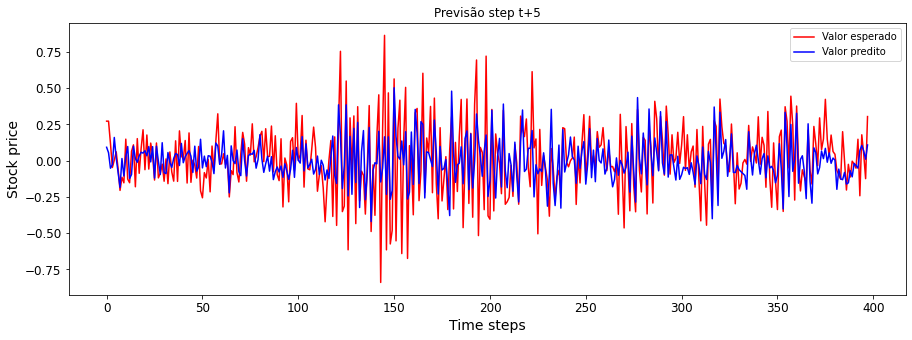

In [66]:
plt.figure(figsize=(15, 5));
plt.plot(y_test[:,4], color='red', label='Valor esperado')
plt.plot(y_pred[:,4], color='blue', label='Valor predito')
plt.title('Previsão step t+5')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### --------------------------------------- 

**6.2.4:** Uma vez que as propriedades estatísticas da série podem variar ao longo do tempo, de forma lenta, uma abordagem possível seria restringir o intervalo de interesse da série para a região mais significativa (durante o treinamento do modelo). Assim, utilizando dados mais atuais garantiriam uma homogeneidade maior das propriedades da série, e viabilizando uma predição mais acurada. Evidente que, nesta abordagem, seria necessário retreinar o modelo periodicamente. Outra possibilidade seria  monitorar as propriedades estatisticas da série e usa-las como entradas do modelo para auxiliar na predição. 